In [2]:
from iads.data_traitement import traitement
from iads.nlp import preprocessing

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from sklearn.multiclass import OneVsRestClassifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# I. Chargement des données :

In [3]:
df_jeux_up = pd.read_csv("../data/details_desc.csv")

In [4]:
df_jeux_up.head()

,Nombre d'avis rectifiés,Note rectifiée,Note Finkel,Nombre d'avis,titre,Note,categories,description,full_title,_id,...,editors,distributors,nb_players,age_required,duration,enfant,ado,adulte,solo,multi
0,10.0,8.40,8.74,19.0,Marvel United,7.58,NaN,marvel united unir contre super vilain red sku...,Marvel United (2020),marvel-united,...,CMON Limited,NaN,1-4,14-99,45.0,0,1,1,1,1
1,17.0,7.29,7.68,33.0,Mariposas,7.39,NaN,annee printemps million papillon monarque quit...,Mariposas (2020),mariposas,...,Gigamic,NaN,2-5,14-99,60.0,0,1,1,0,1
2,9.0,7.22,7.42,28.0,Quetzal,8.18,placement,tete groupe aventurier archeologue expedition ...,Quetzal (2020),quetzal,...,Gigamic,NaN,2-5,8-99,45.0,0,1,1,0,1
3,0.0,0.00,0.00,4.0,Alien - Kit de Démarrage,9.00,NaN,kit demarrage complet plongez horreur boite co...,Alien - Kit de Démarrage (2020),alien-kit-de-demarrage,...,Arkhane Asylum Publishing,NaN,1-99,12-99,NaN,0,1,1,1,1
4,24.0,8.79,9.70,72.0,The LOOP,8.75,gestion,dr foo cree terrrribl machine voyager temps ai...,The LOOP (2020),the-loop,...,Catch Up Games,NaN,1-4,12-99,60.0,0,1,1,1,1


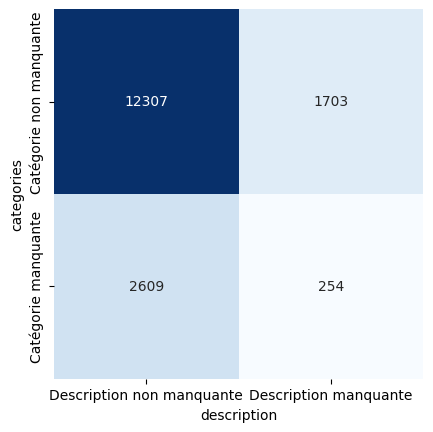

In [5]:
cat_isna  = df_jeux_up["categories"].isna()
desc_isna = df_jeux_up["description"].isna()

table = pd.crosstab(index=cat_isna, columns=desc_isna, margins=False)
table = table.rename(columns={False: 'Description non manquante', True: 'Description manquante'})
table = table.rename(index={False: 'Catégorie non manquante', True: 'Catégorie manquante'})
sns.heatmap(table, annot=True, cmap='Blues', fmt='g', cbar=False, square=True)
plt.show()

- On remarque qu'il y a 12307 jeux avec une description et une catégorie soit 73% de la base de données, qu'on utilisera pour le train de nos classifers.

- Et il y a aussi 1957 jeux sans description, donc des lignes à "supprimer" pour nos classifiers.

- On voit aussi 2609 avec des descriptions mais sans catégorie, cela on s'en servira pour leur génerer une catégorie avec nos prédicteurs

In [6]:
# on recupére les indices 
index_desc_cat = ~cat_isna & ~desc_isna
index_desc_non_cat = cat_isna & ~desc_isna

In [7]:
df_jeux_up[index_desc_cat].head(2)

,Nombre d'avis rectifiés,Note rectifiée,Note Finkel,Nombre d'avis,titre,Note,categories,description,full_title,_id,...,editors,distributors,nb_players,age_required,duration,enfant,ado,adulte,solo,multi
2,9.0,7.22,7.42,28.0,Quetzal,8.18,placement,tete groupe aventurier archeologue expedition ...,Quetzal (2020),quetzal,...,Gigamic,NaN,2-5,8-99,45.0,0,1,1,0,1
4,24.0,8.79,9.70,72.0,The LOOP,8.75,gestion,dr foo cree terrrribl machine voyager temps ai...,The LOOP (2020),the-loop,...,Catch Up Games,NaN,1-4,12-99,60.0,0,1,1,1,1


In [8]:
df_jeux_up[index_desc_non_cat].head(2)

,Nombre d'avis rectifiés,Note rectifiée,Note Finkel,Nombre d'avis,titre,Note,categories,description,full_title,_id,...,editors,distributors,nb_players,age_required,duration,enfant,ado,adulte,solo,multi
0,10.0,8.40,8.74,19.0,Marvel United,7.58,NaN,marvel united unir contre super vilain red sku...,Marvel United (2020),marvel-united,...,CMON Limited,NaN,1-4,14-99,45.0,0,1,1,1,1
1,17.0,7.29,7.68,33.0,Mariposas,7.39,NaN,annee printemps million papillon monarque quit...,Mariposas (2020),mariposas,...,Gigamic,NaN,2-5,14-99,60.0,0,1,1,0,1


# II. TfIdf sur les descriptions :

In [9]:
X_text = df_jeux_up['description'][index_desc_cat]
Y_text = df_jeux_up['categories'][index_desc_cat]

In [10]:
X_text.shape

(12307,)

In [11]:
Y_text.shape

(12307,)

In [12]:
classes = np.unique(Y_text)
print(classes, "\n\n ===> ", len(classes))

['affrontement' 'amateur' 'ambiance' 'animal' 'blocage' 'bluff' 'casual'
 'combinaison' 'connaissance' 'cooperation' 'deduction' 'deplacement'
 'dexterite adresse' 'dé carte' 'exploration' 'famille collection'
 'fantastique' 'figurine' 'gestion' 'guerre' 'hero' 'historique' 'lettre'
 'logique' 'majorite' 'medieval' 'mythe legende conte' 'observation'
 'pion' 'placement' 'plateau' 'rapidite' 'risque prise' 'role'
 'science fiction' 'tete casser'] 

 ===>  36


In [13]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y = encoder.fit_transform(Y_text)

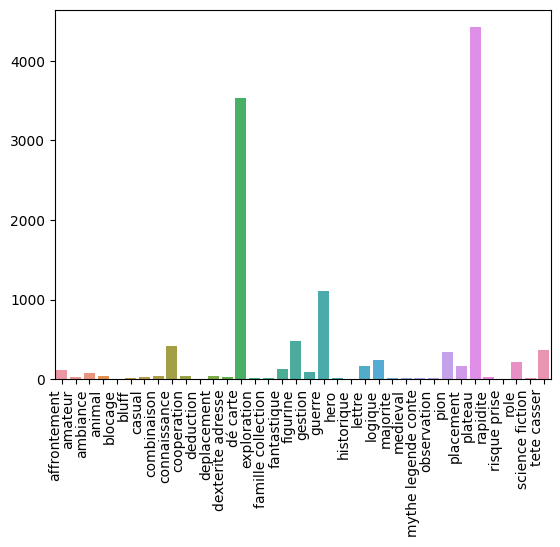

In [14]:
val, count = np.unique(Y_text, return_counts=True)

sns.barplot(x = val, y = count)
plt.xticks(rotation=90, ha='right')
plt.show()

In [15]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=4, ngram_range=(1,1))
X = vectorizer.fit_transform(X_text)
X.shape

(12307, 10740)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [17]:
X_train.shape

(9845, 10740)

In [18]:
X_test.shape

(2462, 10740)

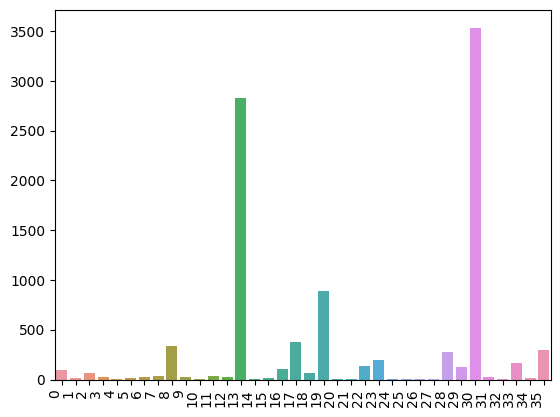

In [19]:
val, count = np.unique(y_train, return_counts=True)

sns.barplot(x = val, y = count)
plt.xticks(rotation=90, ha='right')
plt.show()

In [20]:
# Calculer les proportions des différentes classes dans les données d'entraînement
class_counts = np.bincount(y)
class_weights = class_counts.sum() / class_counts

In [21]:
class_counts

array([ 114,   23,   83,   38,    7,   22,   33,   40,  418,   36,    8,
         47,   30, 3539,   11,   14,  134,  475,   88, 1106,   12,    7,
        171,  247,   11,   12,   10,   10,  348,  163, 4421,   26,    7,
        213,   18,  365], dtype=int64)

In [22]:
class_weights

array([ 107.95614035,  535.08695652,  148.27710843,  323.86842105,
       1758.14285714,  559.40909091,  372.93939394,  307.675     ,
         29.44258373,  341.86111111, 1538.375     ,  261.85106383,
        410.23333333,    3.47753603, 1118.81818182,  879.07142857,
         91.84328358,   25.90947368,  139.85227273,   11.12748644,
       1025.58333333, 1758.14285714,   71.97076023,   49.82591093,
       1118.81818182, 1025.58333333, 1230.7       , 1230.7       ,
         35.36494253,   75.50306748,    2.78375933,  473.34615385,
       1758.14285714,   57.77934272,  683.72222222,   33.71780822])

### Naive Bayes

In [23]:
nb_clf = OneVsRestClassifier(MultinomialNB())
nb_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=MultinomialNB())

In [29]:
# Prédire les classes pour l'ensemble de test
y_pred = nb_clf.predict(X_test)

# Calculer le score F1
f1 = f1_score(y_test, y_pred, average='weighted')

print("Le score F1 du classificateur Naive Bayes est :", f1)


Le score F1 du classificateur Naive Bayes est : 0.5332906077495305


### SVM

In [25]:
svm_clf = OneVsRestClassifier(SVC(kernel='linear'))
svm_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(kernel='linear'))

In [26]:
# Prédire les classes pour l'ensemble de test
y_pred = svm_clf.predict(X_test)

# Calculer le score F1
f1 = f1_score(y_test, y_pred, average='weighted')

print("Le score F1 du classificateur SVM est :", f1)

Le score F1 du classificateur SVM est : 0.6364506277903657


### Random Forest

In [27]:
rf_clf = OneVsRestClassifier(RandomForestClassifier())
rf_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier())

In [28]:
# Prédire les classes pour l'ensemble de test
y_pred = rf_clf.predict(X_test)

# Calculer le score F1
f1 = f1_score(y_test, y_pred, average='weighted')

print("Le score F1 du classificateur Random Forest est :", f1)

Le score F1 du classificateur Random Forest est : 0.6145573396296076
